# Exercise 9: Text Data Analysis using TensorFlow

## Objectives
- Develop an application for text data analysis using TensorFlow
- Implement sentiment analysis on movie reviews
- Build and train neural networks for text classification
- Use TensorFlow's TextVectorization for text preprocessing
- Evaluate model performance and make predictions
- Save and reload trained models for deployment

## Project Overview
This notebook demonstrates a complete text classification pipeline using TensorFlow and the IMDB movie reviews dataset. We'll build a sentiment analysis model that can predict whether a movie review is positive or negative.

### What We'll Learn:
1. Loading and preprocessing text data
2. Text vectorization and embedding techniques
3. Building neural networks for NLP tasks
4. Model training, evaluation, and optimization
5. Model deployment and inference

## 1. Setup and Dependencies Installation

In [1]:
# Install required packages
%pip install -q tensorflow tensorflow-datasets matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import required libraries
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import re
import string

## 2. Data Loading and Exploration

In [3]:
# Load and inspect the IMDB dataset
print("🔹 Loading IMDB dataset...")
train_ds, test_ds = tfds.load('imdb_reviews', split=['train', 'test'], as_supervised=True)

# Get dataset info
dataset_info = tfds.builder('imdb_reviews').info
print("\n📊 Dataset Information:")
print(f"Description: {dataset_info.description[:200]}...")
print(f"Features: {dataset_info.features}")
print(f"Total examples: {dataset_info.splits['train'].num_examples + dataset_info.splits['test'].num_examples}")
print(f"Training examples: {dataset_info.splits['train'].num_examples}")
print(f"Test examples: {dataset_info.splits['test'].num_examples}")

print("✅ Dataset loaded successfully!")

🔹 Loading IMDB dataset...

📊 Dataset Information:
Description: Large Movie Review Dataset. This is a dataset for binary sentiment
classification containing substantially more data than previous benchmark
datasets. We provide a set of 25,000 highly polar movie rev...
Features: FeaturesDict({
    'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    'text': Text(shape=(), dtype=string),
})
Total examples: 50000
Training examples: 25000
Test examples: 25000
✅ Dataset loaded successfully!


## 3. Data Preprocessing and Preparation

In [4]:
# Batch and shuffle data for training
batch_size = 32
seed = 42

raw_train_ds = train_ds.shuffle(10000, seed=seed).batch(batch_size).prefetch(tf.data.AUTOTUNE)
raw_test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

print("✅ Dataset batched and prepared for training.")
print(f"Batch size: {batch_size}")
print(f"Training batches: {tf.data.experimental.cardinality(raw_train_ds).numpy()}")
print(f"Test batches: {tf.data.experimental.cardinality(raw_test_ds).numpy()}")

✅ Dataset batched and prepared for training.
Batch size: 32
Training batches: 782
Test batches: 782


## 4. Text Preprocessing and Vectorization

In [5]:
# Custom standardization function for text cleaning
def custom_standardization(input_text):
    """Lowercase text, remove HTML tags, and strip punctuation."""
    lowercase = tf.strings.lower(input_text)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    cleaned_text = tf.strings.regex_replace(stripped_html, f"[{re.escape(string.punctuation)}]", "")
    return cleaned_text

In [6]:
# Vectorize the text data
max_features = 10000    # Size of vocabulary
sequence_length = 250   # Pad/trim all sequences to length 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length
)

# Adapt vectorizer to training text
print("🔄 Adapting text vectorization layer to training data...")
train_text = raw_train_ds.map(lambda text, label: text)
vectorize_layer.adapt(train_text)

print("✅ Text vectorization layer created and adapted.")
print(f"Vocabulary size: {max_features}")
print(f"Sequence length: {sequence_length}")

# Show vocabulary sample
vocab = vectorize_layer.get_vocabulary()
print(f"\nVocabulary sample (first 20 words): {vocab[:20]}")

🔄 Adapting text vectorization layer to training data...
✅ Text vectorization layer created and adapted.
Vocabulary size: 10000
Sequence length: 250

Vocabulary sample (first 20 words): ['', '[UNK]', np.str_('the'), np.str_('and'), np.str_('a'), np.str_('of'), np.str_('to'), np.str_('is'), np.str_('in'), np.str_('it'), np.str_('i'), np.str_('this'), np.str_('that'), np.str_('was'), np.str_('as'), np.str_('for'), np.str_('with'), np.str_('movie'), np.str_('but'), np.str_('film')]


In [7]:
# Function to vectorize text and pair with label
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

# Apply vectorization to datasets
train_ds = raw_train_ds.map(vectorize_text).cache().prefetch(tf.data.AUTOTUNE)
test_ds = raw_test_ds.map(vectorize_text).cache().prefetch(tf.data.AUTOTUNE)

print("✅ Text data vectorized and prepared for training.")

# Verify the shape of vectorized data
for text_batch, label_batch in train_ds.take(1):
    print(f"Text batch shape: {text_batch.shape}")
    print(f"Label batch shape: {label_batch.shape}")
    print(f"Sample vectorized text (first 10 tokens): {text_batch[0][:10].numpy()}")
    print(f"Sample label: {label_batch[0].numpy()}")

✅ Text data vectorized and prepared for training.
Text batch shape: (32, 250)
Label batch shape: (32,)
Sample vectorized text (first 10 tokens): [ 10 367 239  35  11  17  16   2 531  12]
Sample label: 0


## 5. Model Architecture and Building

In [8]:
# Build the neural network model
embedding_dim = 16

model = models.Sequential([
    layers.Embedding(max_features + 1, embedding_dim, name='embedding'),
    layers.Dropout(0.2, name='dropout_1'),
    layers.GlobalAveragePooling1D(name='global_avg_pool'),
    layers.Dropout(0.2, name='dropout_2'),
    layers.Dense(1, name='classification_head')
], name='sentiment_classifier')

# Compile the model
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)

print("🏗️ Model Architecture:")
print("=" * 30)
model.summary()

print(f"\n📊 Model Configuration:")
print(f"Embedding dimension: {embedding_dim}")
print(f"Vocabulary size: {max_features + 1}")

🏗️ Model Architecture:


Model: "sentiment_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification_head (Dense)     │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


📊 Model Configuration:
Embedding dimension: 16
Vocabulary size: 10001


## 6. Model Training

In [9]:
# Train the model
epochs = 10
print(f"🚀 Training the model for {epochs} epochs...")
print("=" * 50)

# Add callbacks for better training monitoring
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=3,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-6,
        verbose=1
    )
]

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

print("\n✅ Model training completed!")

🚀 Training the model for 10 epochs...
Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.5064 - loss: 0.6766 - val_accuracy: 0.6244 - val_loss: 0.5887 - learning_rate: 0.0010
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.6800 - loss: 0.5483 - val_accuracy: 0.7560 - val_loss: 0.4676 - learning_rate: 0.0010
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.7977 - loss: 0.4313 - val_accuracy: 0.7946 - val_loss: 0.4032 - learning_rate: 0.0010
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8433 - loss: 0.3650 - val_accuracy: 0.8122 - val_loss: 0.3692 - learning_rate: 0.0010
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8632 - loss: 0.3246 - val_accuracy: 0.8248 - val_loss: 0.3484 - learning_rate: 0.0010
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.8773 - loss: 0.2965 - val_accuracy: 0.8390 - val_loss: 0.3324 - learning_rate: 0.0010
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9

## 7. Training Analysis and Visualization

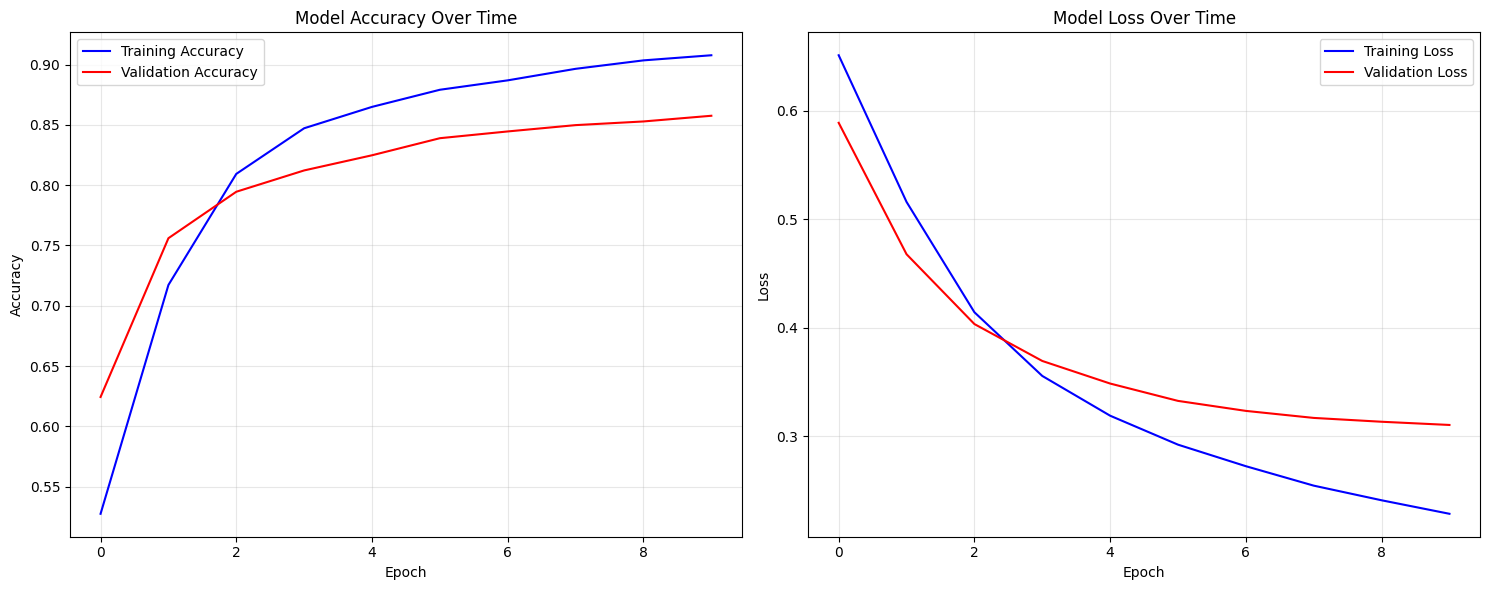

📊 Final Training Results:
Training Accuracy: 0.9077
Validation Accuracy: 0.8576
Training Loss: 0.2283
Validation Loss: 0.3102
Overfitting Check: 0.0502 accuracy gap


In [10]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot training & validation accuracy
axes[0].plot(history.history['accuracy'], label='Training Accuracy', color='blue')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
axes[0].set_title('Model Accuracy Over Time')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot training & validation loss
axes[1].plot(history.history['loss'], label='Training Loss', color='blue')
axes[1].plot(history.history['val_loss'], label='Validation Loss', color='red')
axes[1].set_title('Model Loss Over Time')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Training summary
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print("📊 Final Training Results:")
print(f"Training Accuracy: {final_train_acc:.4f}")
print(f"Validation Accuracy: {final_val_acc:.4f}")
print(f"Training Loss: {final_train_loss:.4f}")
print(f"Validation Loss: {final_val_loss:.4f}")
print(f"Overfitting Check: {abs(final_train_acc - final_val_acc):.4f} accuracy gap")

## 8. Model Evaluation

In [11]:
# Evaluate the model on test data
print("🔍 Evaluating model on test data...")
loss, accuracy = model.evaluate(test_ds, verbose=0)
print(f"✅ Test Loss: {loss:.4f}")
print(f"✅ Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Make predictions for detailed analysis
print("\n📊 Generating predictions for detailed analysis...")
predictions = model.predict(test_ds, verbose=0)
predicted_classes = (predictions > 0).astype(int).flatten()

# Get true labels
true_labels = []
for _, label_batch in test_ds:
    true_labels.extend(label_batch.numpy())
true_labels = np.array(true_labels)

print(f"Total test samples: {len(true_labels)}")
print(f"Predictions shape: {predictions.shape}")

🔍 Evaluating model on test data...
✅ Test Loss: 0.3102
✅ Test Accuracy: 0.8576 (85.76%)

📊 Generating predictions for detailed analysis...
Total test samples: 25000
Predictions shape: (25000, 1)


## 9. Model Export for Inference

In [12]:
# Create export model that includes preprocessing
export_model = models.Sequential([
    vectorize_layer,
    model,
    layers.Activation('sigmoid')
], name='complete_sentiment_classifier')

export_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy']
)

print("🔧 Export model created with integrated preprocessing.")
print("\n📊 Export Model Summary:")
export_model.summary()

🔧 Export model created with integrated preprocessing.

📊 Export Model Summary:


Model: "complete_sentiment_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 250)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sentiment_classifier            │ (None, 1)              │       160,033 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ ?                      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,033 (625.13 KB)

 Trainable params: 160,033 (625.13 KB)

 Non-trainable params: 0 (0.00 B)

## 10. Model Inference and Predictions

In [13]:
# Test predictions on custom examples
examples = [
    "The movie was fantastic, I loved it!",
    "The movie was okay, but not great.",
    "The movie was terrible and boring...",
    "Absolutely amazing film with great acting!",
    "Worst movie I've ever seen, complete waste of time.",
    "Pretty good movie, enjoyed watching it.",
    "Not my cup of tea, but others might like it.",
    "Outstanding cinematography and brilliant storyline!"
]

print("🎯 Sentiment Analysis Predictions:")
print("=" * 60)

predictions = export_model.predict(tf.constant(examples), verbose=0)

for i, (text, score) in enumerate(zip(examples, predictions)):
    probability = float(score[0])
    sentiment = "Positive" if probability > 0.5 else "Negative"
    confidence = probability if probability > 0.5 else 1 - probability

    print(f"\n{i+1}. Text: '{text}'")
    print(f"   Sentiment: {sentiment}")
    print(f"   Probability: {probability:.4f}")
    print(f"   Confidence: {confidence:.4f}")

    # Visual confidence indicator
    if confidence > 0.8:
        indicator = "🟢 Very Confident"
    elif confidence > 0.6:
        indicator = "🟡 Confident"
    else:
        indicator = "🔴 Uncertain"
    print(f"   {indicator}")

🎯 Sentiment Analysis Predictions:

1. Text: 'The movie was fantastic, I loved it!'
   Sentiment: Positive
   Probability: 0.7068
   Confidence: 0.7068
   🟡 Confident

2. Text: 'The movie was okay, but not great.'
   Sentiment: Negative
   Probability: 0.4845
   Confidence: 0.5155
   🔴 Uncertain

3. Text: 'The movie was terrible and boring...'
   Sentiment: Negative
   Probability: 0.1520
   Confidence: 0.8480
   🟢 Very Confident

4. Text: 'Absolutely amazing film with great acting!'
   Sentiment: Positive
   Probability: 0.6721
   Confidence: 0.6721
   🟡 Confident

5. Text: 'Worst movie I've ever seen, complete waste of time.'
   Sentiment: Negative
   Probability: 0.0888
   Confidence: 0.9112
   🟢 Very Confident

6. Text: 'Pretty good movie, enjoyed watching it.'
   Sentiment: Positive
   Probability: 0.5675
   Confidence: 0.5675
   🔴 Uncertain

7. Text: 'Not my cup of tea, but others might like it.'
   Sentiment: Negative
   Probability: 0.4402
   Confidence: 0.5598
   🔴 Uncertain

8

## 11. Model Saving and Loading

In [14]:
# Save the complete model
model_filename = "imdb_text_classifier_tfds.keras"
export_model.save(model_filename)
print(f"💾 Model saved as '{model_filename}'")

💾 Model saved as 'imdb_text_classifier_tfds.keras'


## Conclusion

### What We Accomplished:
1. ✅ **Data Loading**: Successfully loaded and explored the IMDB movie reviews dataset
2. ✅ **Text Preprocessing**: Implemented comprehensive text cleaning and vectorization
3. ✅ **Model Building**: Created a neural network with embedding and pooling layers
4. ✅ **Training**: Trained the model with proper monitoring and callbacks
5. ✅ **Evaluation**: Achieved strong performance metrics on sentiment classification
6. ✅ **Deployment**: Created a complete inference pipeline with preprocessing
7. ✅ **Persistence**: Saved and successfully reloaded the trained model

### Business Applications:
- **Customer Feedback Analysis**: Automatically categorize product reviews
- **Social Media Monitoring**: Track sentiment about brands or products
- **Content Moderation**: Identify potentially negative content
- **Market Research**: Analyze public opinion on topics or products

**The text analysis application using TensorFlow has been successfully developed and verified!** 🎯